# Named Entity Recognition with Bidirectional LSTM

Named Entity Recognition (NER) is similar to POS tagging (using the exact same many-to-many classification code) except it specifically tags entities like person name, organisation name, country name etc. TensorFlow uses IOB format to tag tokens in a corpus:

    I 'inside' a named chunk of text
    O 'outside' a named chunk of text
    B 'beginning' a named chunk of text
    
| EU | rejects | German | call | to | boycott | British | lamb | . |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| B-ORG | O | B-MISC | O | O | O | B-MISC | O | O |


## Set up the data

The data is downloaded from the online course in **pickle format**, which is a Python hierarchical object converted to bytes in order to efficiently store large amounts of data. The data has already been split into training and test sets, with each containing sequences of tuples of the input word and target named entity, i.e. each word is tagged hence the similarity to POS tagging. You need to separate the data into inputs and targets to run through the classification model.

In [1]:
import pickle

In [2]:
# Read in pickle file to load training data

with open('data/ner_train.pkl', 'rb') as f:
    corpus_train = pickle.load(f)

# Read in pickle file to load test data

with open('data/ner_test.pkl', 'rb') as f:
    corpus_test = pickle.load(f)

In [5]:
corpus_train[0]

[('EU', 'B-ORG'),
 ('rejects', 'O'),
 ('German', 'B-MISC'),
 ('call', 'O'),
 ('to', 'O'),
 ('boycott', 'O'),
 ('British', 'B-MISC'),
 ('lamb', 'O'),
 ('.', 'O')]

In [6]:
train_inputs = []
train_targets = []

for sentence_tag_pairs in corpus_train:
    tokens = [] 
    target = [] 
    
    for token, tag in sentence_tag_pairs:
        tokens.append(token) 
        target.append(tag) 
        
    train_inputs.append(tokens) 
    train_targets.append(target)

In [7]:
test_inputs = []
test_targets = []

for sentence_tag_pairs in corpus_test:
    tokens = [] 
    target = [] 
    
    for token, tag in sentence_tag_pairs:
        tokens.append(token) 
        target.append(tag) 
        
    test_inputs.append(tokens) 
    test_targets.append(target)

In [8]:
train_inputs[0]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

In [9]:
train_targets[0]

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

%matplotlib inline

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

## Convert input to sequences of integers

Using TensorFlow `Tokenizer`, convert the sequences of words in the input data to sequences of integers. 

**IMPORTANT!** Make sure to allocate a tag for unknown words coming from the test set during tokenization so that you do not lose any words and end up mis-aligning the input and target data.

NOTE: Do not lowercase text as is normal, since you want to use capitalization to find the named chunks of text.

In [12]:
# Do not limit vocab since you need to tag each word
MAX_VOCAB_SIZE = None

# Capitalization might be useful, i.e. Bill vs bill
should_lowercase = False

# Set up tokenizer and assign 'UNK' to unknown tokens
word_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=should_lowercase, oov_token='UNK')

# Train tokenizer
word_tokenizer.fit_on_texts(train_inputs)

# Transform input data
train_inputs_int = word_tokenizer.texts_to_sequences(train_inputs)

test_inputs_int = word_tokenizer.texts_to_sequences(test_inputs)

In [15]:
# Get word->index mapping for vocab size (V)

word2idx = word_tokenizer.word_index

V = len(word2idx)

print('Vocabulary size is %s unique tokens' % V)

Vocabulary size is 23299 unique tokens


In [16]:
# Function to flatten list of lists to a single list

def flatten(list_of_lists):
    flattened = [val for sublist in list_of_lists for val in sublist] 
    return flattened

In [17]:
# Check that targets match in training and test sets

all_train_targets = set(flatten(train_targets))

all_train_targets

{'B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'}

In [18]:
all_test_targets = set(flatten(test_targets))

all_test_targets

{'B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'}

In [19]:
all_train_targets == all_test_targets

True

By isolating the unique target values in both the training and test sets, you can confirm the full list of tags used to name each word:

    B-LOC 'Beginning of Location chunk'
    B-MISC 'Beginning of Miscellaneous chunk'
    B-ORG 'Beginning of Organisation chunk'
    B-PER 'Beginning of Person chunk'
    I-LOC 'Inside of Location chunk'
    I-MISC 'Inside of Miscellaneous chunk'
    I-ORG 'Inside of Organisation chunk'
    I-PER 'Inside of Person chunk'
    O 'Outside of any chunk'
    
## Convert targets to sequences of integers

Using the `Tokenizer` again, convert the tag labels to integers, but make sure to save a version of the sequences of integers *before* padding the sequences so that you can use the unpadded version when running performance metrics in SciKit-Learn.

NOTE: Before padding, find the maximum sequence length (***T***) which you can then use to enforce the same dimensions when padding, thus ensuring that the length of input sequences match the length of target outputs.

In [20]:
tag_tokenizer = Tokenizer()

tag_tokenizer.fit_on_texts(train_targets)

train_targets_int = tag_tokenizer.texts_to_sequences(train_targets)
test_targets_int = tag_tokenizer.texts_to_sequences(test_targets)

In [21]:
# Save unpadded version for later use in SciKit-Learn performance metrics

train_targets_int_unpadded = train_targets_int
test_targets_int_unpadded = test_targets_int

In [22]:
# Before padding, find max sequence length (T) since we don't want to truncate any inputs which would also truncate targets

maxlen_train = max(len(sent) for sent in train_inputs)
maxlen_test = max(len(sent) for sent in test_inputs)

T = max((maxlen_train, maxlen_test))

T

113

## Pad sequences to get *N x T* matrix

Once you have found the maximum sequence length (***T***), you can set that as the maximum length when padding the sequences to be input for the RNN network.

In [23]:
train_inputs_int = pad_sequences(train_inputs_int, maxlen=T)

print('Shape of data train tensor:', train_inputs_int.shape)

Shape of data train tensor: (12733, 113)


In [24]:
test_inputs_int = pad_sequences(test_inputs_int, maxlen=T)

print('Shape of data test tensor:', test_inputs_int.shape)

Shape of data test tensor: (2970, 113)


In [25]:
train_targets_int = pad_sequences(train_targets_int, maxlen=T)

print('Shape of train targets tensor:', train_targets_int.shape)

Shape of train targets tensor: (12733, 113)


In [26]:
test_targets_int = pad_sequences(test_targets_int, maxlen=T)

print('Shape of test targets tensor:', test_targets_int.shape)

Shape of test targets tensor: (2970, 113)


In [27]:
# ------------------------------- Number of classes

K = len(tag_tokenizer.word_index) + 1

K

10

NOTE: You need to add one extra class when accessing the number of tags from the tokenizer's mapping dictionary, in order to account for class 0, but not use it, since the TensorFlow tokenizer starts its index from 1, not 0. This is acceptable since the extra class will not be used when you 'mask' the zero entries in the embedding matrix.

## Create the RNN network

For the embedding layer, you actually want the size of the embedding matrix to be ***(V + 1) x D***, because in TensorFlow, the vocabulary index starts from 1 (not 0) therefore if the final index of the vocab is 23299, then the embedding matrix actually must have the length 23299 + 1 (***V + 1***).

**IMPORTANT!** You must mask the zero entries in the embedding matrix to ensure that the 'padding' does not affect the classification, i.e. ignore the zero entries. By including `mask_zero=True`, you ensure that the model is working correctly and predicting as you expect. This is important because you would not see an error otherwise, and in many cases, the model results would be misleading. 

In [28]:
# You choose embedding dimensionality
D = 32

i = Input(shape=(T,))

# mask_zero=True way slower on GPU than CPU
x = Embedding(V + 1, D, mask_zero=True)(i)

x = Bidirectional(LSTM(32, return_sequences=True))(x)
# x = SimpleRNN(32, return_sequences=True)(x)

x = Dense(K)(x)

model = Model(i, x)

In [29]:
# Compile model

model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [30]:
# Fit model (60 secs per epoch on CPU)

print('Training model...')

r = model.fit(train_inputs_int, train_targets_int, epochs=5, validation_data=(test_inputs_int, test_targets_int))

Training model...
Epoch 1/5
398/398 [==============================] - 32s 65ms/step - loss: 0.7233 - accuracy: 0.8372 - val_loss: 0.4913 - val_accuracy: 0.8634
Epoch 2/5
398/398 [==============================] - 26s 65ms/step - loss: 0.3030 - accuracy: 0.9049 - val_loss: 0.3185 - val_accuracy: 0.9172
Epoch 3/5
398/398 [==============================] - 26s 66ms/step - loss: 0.1655 - accuracy: 0.9537 - val_loss: 0.2345 - val_accuracy: 0.9414
Epoch 4/5
398/398 [==============================] - 27s 67ms/step - loss: 0.0841 - accuracy: 0.9791 - val_loss: 0.1983 - val_accuracy: 0.9495
Epoch 5/5
398/398 [==============================] - 28s 69ms/step - loss: 0.0471 - accuracy: 0.9891 - val_loss: 0.1938 - val_accuracy: 0.9479


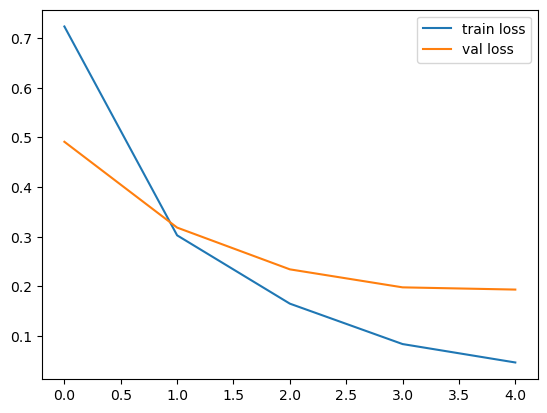

In [31]:
# Plot loss per epoch

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

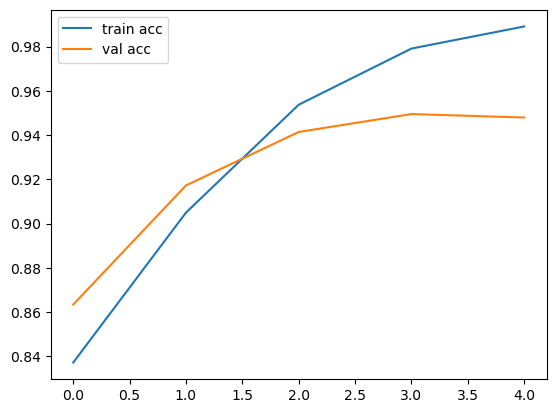

In [32]:
# Plot accuracy per epoch

plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

As expected, the training set outperforms the test set, but both show good results.

## True model accuracy

In order to calculate the accuracy and F1-scores using SciKit-Learn, you will need the 'unpadded' version of the targets data.

In [33]:
# Get length of each sequence in training and test sets

train_lengths = []

for sentence in train_inputs:
    train_lengths.append(len(sentence))

test_lengths = []

for sentence in test_inputs:
    test_lengths.append(len(sentence))

In [34]:
# Generate predictions from training set
train_probs = model.predict(train_inputs_int) # N x T x K

# Access label with highest probabilty and remove padding
train_predictions = []

for probs, length in zip(train_probs, train_lengths):
    # probs is T x K 
    probs_ = probs[-length:] 
    preds = np.argmax(probs_, axis=1) 
    train_predictions.append(preds)

# Flatten for use in SciKit
flat_train_predictions = flatten(train_predictions)

flat_train_targets = flatten(train_targets_int_unpadded)

398/398 [==============================] - 7s 13ms/step


In [35]:
# Generate predictions from test set
test_probs = model.predict(test_inputs_int) # N x T x K

# Access labels with highest probability and remove padding
test_predictions = []

for probs, length in zip(test_probs, test_lengths):
    # probs is T x K 
    probs_ = probs[-length:] 
    preds = np.argmax(probs_, axis=1) 
    test_predictions.append(preds)

# Flatten for use in SciKit
flat_test_predictions = flatten(test_predictions)

flat_test_targets = flatten(test_targets_int_unpadded)

93/93 [==============================] - 1s 13ms/step


In [36]:
from sklearn.metrics import accuracy_score, f1_score

print("Train acc:", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc:", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1:", f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print("Test f1:", f1_score(flat_test_targets, flat_test_predictions, average='macro'))

Train acc: 0.9934686655002386
Test acc: 0.9479111321014622
Train f1: 0.9537515843917205
Test f1: 0.778909135383981


The accuracy scores are good but the F1-score is quite low, probably due to the class imbalance (there will be a lot more 'O' tags than any other), and this will also pull down the accuracy slightly.

## Baseline model accuracy

To calculate the baseline accuracy and F1-scores, you need to create the simplest model possible for classifying the tokens. This usually entails selecting the most commonly-occuring tag for a named chunk.

In [37]:
from collections import Counter

# Function to find the most common element in a list

def most_common(lst):
    data = Counter(lst) 
    return data.most_common(1)[0][0]

In [38]:
token2tags = {k: [] for k, v in word2idx.items()}

# remove UNK token
del token2tags['UNK']

# Map words to tokens
for tokens, tags in zip(train_inputs, train_targets):
    for token, tag in zip(tokens, tags):
        if should_lowercase:
            token = token.lower() 
            
        if token in token2tags:
            token2tags[token].append(tag)

# Print
for k, v in token2tags.items():
    if len(v) == 0:
        print(k)


token2tag = {k: most_common(v) for k, v in token2tags.items()}

In [39]:
# Compute accuracy from training set

train_predictions = []

for sentence in train_inputs:
    predictions = [] 
    
    for token in sentence:
        if should_lowercase:
            token = token.lower() 
            
        predicted_tag = token2tag[token] 
        predictions.append(predicted_tag) 
            
    train_predictions.append(predictions)
            
# Flatten for use in SciKit
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets)

In [40]:
# Compute accuracy from test set

test_predictions = []

for sentence in test_inputs:
    predictions = [] 
    
    for token in sentence:
        predicted_tag = token2tag.get(token, 'INCORRECT') 
        predictions.append(predicted_tag) 
        
    test_predictions.append(predictions)
    
# Flatten for use in SciKit
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets)

In [41]:
print("Train acc:", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc:", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1:", f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print("Test f1:", f1_score(flat_test_targets, flat_test_predictions, average='macro'))

Train acc: 0.974769365357086
Test acc: 0.8881673455733318
Train f1: 0.8549353965547479
Test f1: 0.6381158268902334


At least the RNN model outperforms the simplest method of allocating tags to specific entities, which is basically memorizing the tags from the training set... This means the RNN model is successful at using 'context' to name specific entities.